In [1]:
from obs_models import *
from generate_data import *
from utils import *
%matplotlib inline

In [2]:
from pyro.contrib.autoguide import AutoLowRankMultivariateNormal

In [3]:
from scipy.stats import multivariate_normal

In [4]:
N, D = 1000, 10
random_covariance_factor = np.random.rand(D,D)*np.random.randint(2,size=D*D).reshape(D,D)
random_covariance = np.matmul(random_covariance_factor,random_covariance_factor.T)
random_data = multivariate_normal(cov=random_covariance).rvs(size=N)

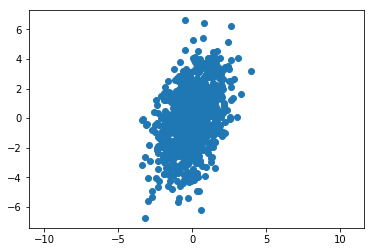

In [5]:
# plot two random dimensions against each other
pyplot.scatter(*random_data[:,np.random.choice(np.arange(D),size=2,replace=False)].T)
pyplot.axis('equal');

In [6]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
print(random_covariance_factor)
print(random_covariance)
print(np.cov(random_data.T))

[[0.00 0.00 0.13 0.00 0.00 0.00 0.71 0.44 0.52 0.00]
 [1.00 0.09 0.52 0.00 0.84 0.05 0.48 0.49 0.43 0.37]
 [0.59 0.00 0.00 0.06 0.13 0.00 0.30 0.00 0.00 0.00]
 [0.00 0.55 0.00 0.09 0.00 0.00 0.00 0.00 0.00 0.00]
 [0.70 0.93 0.81 0.73 0.32 0.00 1.00 0.41 0.36 0.00]
 [0.00 0.28 0.96 0.00 0.31 0.72 0.00 0.42 0.00 0.30]
 [0.12 0.00 0.00 0.74 0.57 0.00 0.00 0.92 0.00 0.70]
 [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.38 0.08]
 [0.00 0.00 0.46 0.02 0.99 0.00 0.14 0.00 0.00 0.18]
 [0.58 0.93 0.00 0.00 0.01 0.00 0.00 0.54 0.00 0.87]]
[[0.98 0.85 0.21 0.00 1.18 0.31 0.40 0.20 0.16 0.24]
 [0.85 2.78 0.84 0.05 2.31 1.14 1.31 0.19 1.21 1.27]
 [0.21 0.84 0.45 0.01 0.79 0.04 0.19 0.00 0.17 0.34]
 [0.00 0.05 0.01 0.32 0.58 0.15 0.07 0.00 0.00 0.51]
 [1.18 2.31 0.79 0.58 3.93 1.31 1.19 0.14 0.85 1.49]
 [0.31 1.14 0.04 0.15 1.31 1.88 0.77 0.03 0.81 0.75]
 [0.40 1.31 0.19 0.07 1.19 0.77 2.21 0.06 0.71 1.18]
 [0.20 0.19 0.00 0.00 0.14 0.03 0.06 0.15 0.01 0.07]
 [0.16 1.21 0.17 0.00 0.85 0.81 0.71 0.01 1.2

In [7]:
data = torch.tensor(random_data,dtype=torch.float32)

In [8]:
#pyro.distributions.AVFMultivariateNormal

In [9]:
#torch.cholesky(torch.matmul(cov_factor,cov_factor.transpose(0,1)))

In [10]:
def factorAnalysis(data):
    N, D = data.shape
    loc = pyro.sample('loc',dst.Normal(torch.zeros(D),10.).to_event(1))
    cov_factor = torch.zeros((D,D))
    with pyro.plate('feature_plate', D) as feature:
        cov_factor_column = pyro.sample('cov_factor_column', dst.Normal(torch.zeros(D),10.).to_event(1))
        cov_factor[:,feature] = cov_factor_column
    #cov_factor = pyro.sample('cov_factor',dst.Normal(torch.zeros((D,D)),10.))
    cov_diag = pyro.sample('cov_diag', dst.LogNormal(torch.zeros(D),4.).to_event(1))
    with pyro.plate('data', N):
        data = pyro.sample('obs', dst.LowRankMultivariateNormal(loc, cov_factor=cov_factor, cov_diag=cov_diag))
    return data

In [11]:
observedFactorAnalysis = pyro.condition(factorAnalysis, data = {'obs': data})

In [12]:
observedFactorAnalysis(data)

tensor([[ 9.0831e-02,  3.7867e-01,  1.7931e-01,  ..., -5.7737e-02,
          6.3324e-01, -2.1740e+00],
        [-2.1089e-01, -3.1428e+00, -1.0661e+00,  ...,  2.2470e-02,
         -1.1163e+00, -4.4297e+00],
        [-1.0421e+00,  1.3711e+00,  6.4975e-01,  ..., -4.6846e-01,
          1.2080e+00,  9.8486e-01],
        ...,
        [ 5.8497e-01,  2.1938e+00,  5.8299e-01,  ...,  2.6731e-01,
          7.3488e-01,  2.0262e+00],
        [-4.3871e-01, -2.6580e-01, -3.4361e-02,  ...,  2.8062e-03,
          7.8323e-02, -1.5739e+00],
        [-6.6086e-01, -1.1030e+00, -2.6725e-01,  ..., -6.8584e-02,
         -3.4888e-01, -1.0662e+00]])

In [13]:
#guide = AutoLowRankMultivariateNormal(poutine.block(factorAnalysis,expose=['loc','cov_factor','cov_diag']))

In [14]:
def factorAnalysisGuide(data):
    N, D = data.shape
    K = D
    loc_mean = pyro.param('loc_mean', torch.zeros(D, requires_grad = False))
    loc_scale = pyro.param('loc_scale', torch.ones(D), constraint=constraints.positive)
    # in the model, cov_factor_columns share the mean and variance
    # in the guide, each column has its own
    cov_factor_mean = pyro.param('cov_factor_mean', torch.zeros(D,K))
    cov_factor_scale = pyro.param('cov_factor_scale', torch.ones(D,K), constraint=constraints.positive)
    cov_diag_mean = pyro.param('cov_diag_mean', torch.zeros(D))
    cov_diag_scale = pyro.param('cov_diag_scale', torch.ones(D), constraint=constraints.positive)
    loc = pyro.sample('loc', dst.Normal(loc_mean,loc_scale).to_event(1))
    cov_factor = torch.zeros((D,D))
    with pyro.plate('feature_plate', D) as feature:
        cov_factor_column = pyro.sample('cov_factor_column', dst.Normal(cov_factor_mean, cov_factor_scale).to_event(1))
        cov_factor[:,feature] = cov_factor_column
    cov_diag = pyro.sample('cov_diag', dst.LogNormal(cov_diag_mean, cov_diag_scale).to_event(1))
    return loc, cov_factor, cov_diag

In [15]:
#pyro.clear_param_store()
trace = pyro.poutine.trace(observedFactorAnalysis).get_trace(data)
guide_trace = pyro.poutine.trace(factorAnalysisGuide).get_trace(data)
pyro.util.check_model_guide_match(trace, guide_trace)
print(pyro.get_param_store().named_parameters(),sep='\n')

dict_items([('loc_mean', tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)), ('loc_scale', tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)), ('cov_factor_mean', tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True)), ('cov_factor_scale', tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     

In [16]:
def per_param_callable(module_name, param_name):
    if param_name == 'loc_mean':
        return {"lr": 0.0, 'betas': [0.9, 0.99]}
    else:
        return {"lr": 0.01, 'betas': [0.9, 0.99]}

In [17]:
#optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.999]})
#optim = pyro.optim.Adam({'lr': 0.005, 'betas': [0.9, 0.999]})
#optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.99]})
#optim = pyro.optim.Adam({'lr': 0.005, 'betas': [0.9, 0.99]})
#optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.99]})
optim = pyro.optim.Adam(per_param_callable)
elbo = Trace_ELBO()
svi = SVI(observedFactorAnalysis, factorAnalysisGuide, optim, loss=elbo)

In [18]:
def initialize(seed):
    # evaluate loss on a randomly initialized parameter-set 
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    # guide param names were defined by AutoDelta, with names copied from model and prefixed by 'auto_'
    # Initialize means to a single sample of data.
    #pyro.param('auto_loc', data[torch.multinomial(torch.ones(len(data)) / len(data), 1)]);
    #pyro.param('auto_scale', (data.var(0) / 2).sqrt(), constraint=constraints.positive)
    # WHY DO I GET AN ERROR WHEN USING PYRO.CONDITION?
    #loss = svi.loss(cond_model, global_guide, data)
    loss = svi.loss(factorAnalysis, guide, data)
    return loss

In [19]:
# Choose the best among 100 random initializations.
#loss, seed = min((initialize(seed), seed) for seed in range(100))
#initialize(seed)
#print('seed = {}, initial_loss = {}'.format(seed, loss))

In [20]:
pyro.get_param_store().named_parameters()

dict_items([('loc_mean', tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)), ('loc_scale', tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)), ('cov_factor_mean', tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True)), ('cov_factor_scale', tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     

In [21]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
# while not all parameters are locked:
# for parameter in parameters:
# lock parameter if gradient_norm is below tolerance
for i in range(2000):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

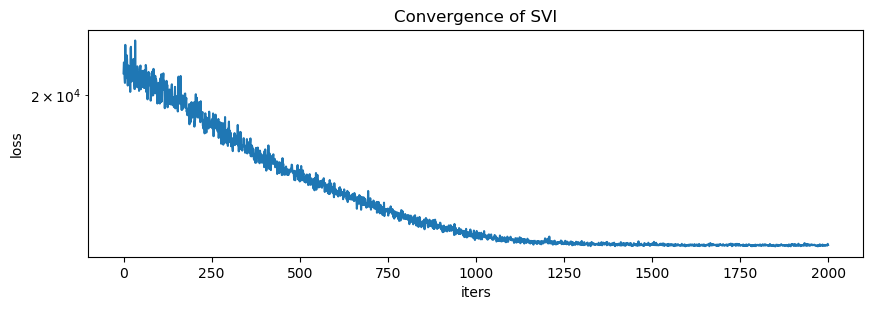

In [22]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

In [23]:
for name, node in trace.nodes.items():
    print(name,node["type"])

_INPUT args
loc sample
feature_plate sample
cov_factor_column sample
cov_diag sample
data sample
obs sample
_RETURN return


In [24]:
for name, node in guide_trace.nodes.items():
    print(node["type"])

args
param
param
param
param
param
param
sample
sample
sample
sample
return


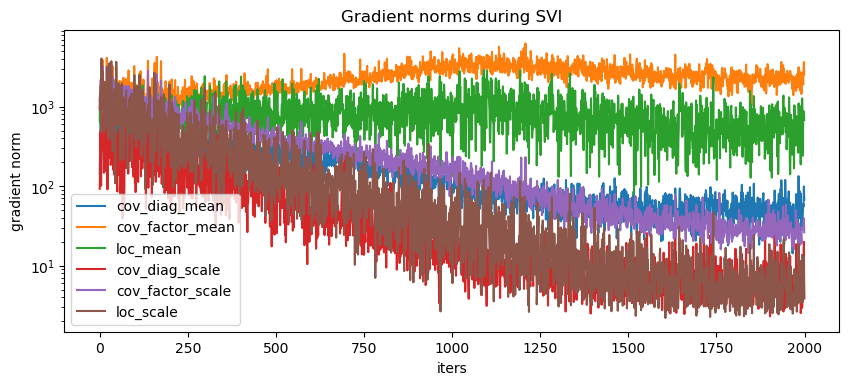

In [25]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [26]:
dict(pyro.get_param_store())

{'loc_mean': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True),
 'loc_scale': tensor([0.0186, 0.0085, 0.0056, 0.0056, 0.0175, 0.0213, 0.0287, 0.0068, 0.0148,
         0.0146], grad_fn=<AddBackward0>),
 'cov_factor_mean': tensor([[ 2.0793e-01, -2.3218e-01, -2.3637e-01,  3.4407e-02,  4.0267e-02,
           7.4366e-01, -1.5375e-01, -2.6276e-01,  2.3545e-01,  3.9147e-03],
         [ 3.2808e-02, -5.1145e-01, -6.7321e-01,  1.2865e-01, -4.7673e-02,
           1.0690e+00, -6.9977e-01,  8.1218e-01, -7.0649e-02,  1.1215e-01],
         [ 4.8904e-02, -2.0474e-01, -5.2843e-01,  4.8328e-02,  3.3391e-02,
           1.9521e-01, -7.4850e-02,  1.9830e-01, -2.4808e-01,  3.5761e-02],
         [ 1.6905e-01, -7.3149e-05,  1.5193e-01,  1.7342e-02, -2.9916e-02,
           1.7765e-01,  3.9337e-01,  2.4483e-01, -1.3618e-01, -2.8339e-03],
         [ 1.5672e-01, -4.3285e-01, -3.4099e-01,  1.1139e-01,  7.6321e-02,
           1.7330e+00,  2.1239e-01,  3.1827e-01, -6.9190e-01,  8.9725e-02],
      

In [27]:
cov_factor_est = pyro.get_param_store()['cov_factor_mean']

In [28]:
# mode of lognormal is exp(mu - sigma^2)
cov_diag_est = torch.exp(pyro.get_param_store()['cov_diag_mean'] - pyro.get_param_store()['cov_diag_scale']**2)

In [29]:
total_cov_est = torch.matmul(cov_factor_est,cov_factor_est.transpose(0,1)) + torch.diag(cov_diag_est)

In [30]:
total_cov_est

tensor([[ 1.0259,  0.9602,  0.2319, -0.0261,  1.2305,  0.3630,  0.4729,  0.2191,
          0.2253,  0.2803],
        [ 0.9602,  3.0495,  0.9103,  0.0297,  2.4882,  1.2073,  1.5066,  0.2350,
          1.3799,  1.3730],
        [ 0.2319,  0.9103,  0.4740,  0.0153,  0.8448,  0.0508,  0.2167,  0.0186,
          0.2272,  0.4141],
        [-0.0261,  0.0297,  0.0153,  0.3239,  0.5377,  0.0776,  0.0451, -0.0053,
         -0.0292,  0.5294],
        [ 1.2305,  2.4882,  0.8448,  0.5377,  4.0024,  1.2756,  1.2905,  0.1782,
          0.9535,  1.5719],
        [ 0.3630,  1.2073,  0.0508,  0.0776,  1.2756,  1.9280,  0.8173,  0.0523,
          0.8384,  0.6672],
        [ 0.4729,  1.5066,  0.2167,  0.0451,  1.2905,  0.8173,  2.4610,  0.0655,
          0.8543,  1.2071],
        [ 0.2191,  0.2350,  0.0186, -0.0053,  0.1782,  0.0523,  0.0655,  0.1491,
          0.0284,  0.0716],
        [ 0.2253,  1.3799,  0.2272, -0.0292,  0.9535,  0.8384,  0.8543,  0.0284,
          1.3174,  0.2019],
        [ 0.2803,  

In [31]:
random_covariance

array([[0.98, 0.85, 0.21, 0.00, 1.18, 0.31, 0.40, 0.20, 0.16, 0.24],
       [0.85, 2.78, 0.84, 0.05, 2.31, 1.14, 1.31, 0.19, 1.21, 1.27],
       [0.21, 0.84, 0.45, 0.01, 0.79, 0.04, 0.19, 0.00, 0.17, 0.34],
       [0.00, 0.05, 0.01, 0.32, 0.58, 0.15, 0.07, 0.00, 0.00, 0.51],
       [1.18, 2.31, 0.79, 0.58, 3.93, 1.31, 1.19, 0.14, 0.85, 1.49],
       [0.31, 1.14, 0.04, 0.15, 1.31, 1.88, 0.77, 0.03, 0.81, 0.75],
       [0.40, 1.31, 0.19, 0.07, 1.19, 0.77, 2.21, 0.06, 0.71, 1.18],
       [0.20, 0.19, 0.00, 0.00, 0.14, 0.03, 0.06, 0.15, 0.01, 0.07],
       [0.16, 1.21, 0.17, 0.00, 0.85, 0.81, 0.71, 0.01, 1.25, 0.17],
       [0.24, 1.27, 0.34, 0.51, 1.49, 0.75, 1.18, 0.07, 0.17, 2.25]])

In [32]:
rel_err(random_covariance, total_cov_est)

tensor(0.0836, grad_fn=<DivBackward0>)

In [33]:
sample_sites = []
for name, node in trace.nodes.items():
    if node['type'] is 'sample' and not node['is_observed']:
        sample_sites.append(node)

In [34]:
variatonal_posterior_sample = dict(zip(['loc','cov_factor_column','cov_diag'],factorAnalysisGuide(data)))

In [35]:
posterior_predictive = pyro.condition(factorAnalysis, data = variatonal_posterior_sample)

In [36]:
posterior_predictive_check = posterior_predictive(data)

In [37]:
posterior_predictive_check = posterior_predictive_check.detach().numpy()

In [38]:
pyro.param("loc_mean")

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

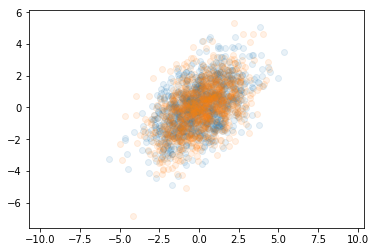

In [39]:
# plot two random dimensions against each other
random_idxs = np.random.choice(np.arange(D),size=2,replace=False)
pyplot.scatter(*random_data[:,random_idxs].T, alpha=.1)
pyplot.scatter(*posterior_predictive_check[:,random_idxs].T, alpha=.1)
pyplot.axis('equal');

In [40]:
std_normal = pyro.distributions.Normal(loc=0,scale=1)

In [41]:
std_normal.entropy(),np.log2(np.exp(1))*std_normal.entropy()

(tensor(1.4189), tensor(2.0471))

In [42]:
bern = pyro.distributions.Bernoulli(probs=0.5)

In [43]:
np.log2(np.exp(1))*bern.entropy()

tensor(1.)